In [ ]:
!pip install transformers

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from transformers import BertTokenizer, TFBertModel

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_path = "/content/gdrive/MyDrive/Code/Restaurent_data/augmented_data_restaurant_bert.csv"
df = pd.read_csv(data_path)
df = df[['text', 'aspect_category']].dropna().reset_index(drop=True)


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
max_len = 128
batch_size = 32

# Tokenize
encoded = tokenizer(
    df['text'].tolist(),
    padding=True,
    truncation=True,
    max_length=max_len,
    return_tensors='tf'
)

input_ids = encoded['input_ids']
attention_masks = encoded['attention_mask']

# Label encode
labels = LabelEncoder().fit_transform(df['aspect_category'])
y = to_categorical(labels)

In [ ]:
# from tqdm import tqdm
# import tensorflow as tf  # Make sure you're using TF-based BERT model

# def extract_bert_embeddings(input_ids, attention_masks, batch_size=32):
#     all_embeddings = []
#     for i in tqdm(range(0, input_ids.shape[0], batch_size), desc="Extracting BERT Embeddings"):
#         inputs = input_ids[i:i+batch_size]
#         masks = attention_masks[i:i+batch_size]
#         outputs = bert_model(inputs, attention_mask=masks, training=False)
#         cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
#         all_embeddings.append(cls_embeddings)
#     return tf.concat(all_embeddings, axis=0)

# # Usage
# X = extract_bert_embeddings(input_ids, attention_masks, batch_size=32)


In [ ]:
!pip install tqdm
from tqdm import tqdm  # Import tqdm

# Graph-compiled function to get CLS embeddings
@tf.function
def get_bert_embeddings(inputs, masks):
    outputs = bert_model(inputs, attention_mask=masks, training=False)
    return outputs.last_hidden_state[:, 0, :]  # CLS token

# Embedding extraction function using tf.data
def extract_bert_embeddings(input_ids, attention_masks, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    all_embeddings = []
    for batch_input_ids, batch_attention_masks in tqdm(dataset, desc="Extracting BERT Embeddings"):  # Use tqdm here
        cls_embeddings = get_bert_embeddings(batch_input_ids, batch_attention_masks)
        all_embeddings.append(cls_embeddings)

    return tf.concat(all_embeddings, axis=0)

# Run embedding extraction
X = extract_bert_embeddings(input_ids, attention_masks, batch_size=16)
print("Extracted embeddings shape:", X.shape)

Extracting BERT Embeddings: 100%|██████████| 381/381 [37:33<00:00,  5.91s/it]

Extracted embeddings shape: (6088, 768)


In [ ]:
# # Graph-compiled function to get CLS embeddings
# @tf.function
# def get_bert_embeddings(inputs, masks):
#     outputs = bert_model(inputs, attention_mask=masks, training=False)
#     return outputs.last_hidden_state[:, 0, :]  # CLS token

# # Embedding extraction function using tf.data
# def extract_bert_embeddings(input_ids, attention_masks, batch_size=32):
#     dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks))
#     dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

#     all_embeddings = []
#     for batch_input_ids, batch_attention_masks in tqdm(dataset, desc="Extracting BERT Embeddings"):
#         cls_embeddings = get_bert_embeddings(batch_input_ids, batch_attention_masks)
#         all_embeddings.append(cls_embeddings)

#     return tf.concat(all_embeddings, axis=0)

# # Run embedding extraction
# X = extract_bert_embeddings(input_ids, attention_masks, batch_size=16)
# print("Extracted embeddings shape:", X.shape)

In [ ]:
# from tqdm import tqdm

# def extract_bert_embeddings(input_ids, attention_masks):
#     all_embeddings = []
#     for i in tqdm(range(0, input_ids.shape[0], batch_size), desc="Extracting BERT Embeddings"):
#         inputs = input_ids[i:i+batch_size]
#         masks = attention_masks[i:i+batch_size]
#         outputs = bert_model(inputs, attention_mask=masks, training=False)
#         cls_embeddings = outputs.last_hidden_state[:, 0, :]
#         all_embeddings.append(cls_embeddings)
#     return tf.concat(all_embeddings, axis=0)

# X = extract_bert_embeddings(input_ids, attention_masks)


In [ ]:
# outputs = bert_model(input_ids, attention_mask=attention_masks, training=False)
# X = outputs.last_hidden_state[:, 0, :]  # CLS token

In [ ]:
latent_dim = 128
output_dim = X.shape[1]
num_classes = y.shape[1]

def build_generator(latent_dim, output_dim):
    model = models.Sequential([
        layers.Dense(256, input_dim=latent_dim),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(),
        layers.Dense(512),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(),
        layers.Dense(output_dim, activation='tanh')
    ])
    return model

def build_discriminator(input_dim, output_dim):
    model = models.Sequential([
        layers.Dense(512, input_dim=input_dim),
        layers.LeakyReLU(0.2),
        layers.Dense(256),
        layers.LeakyReLU(0.2),
        layers.Dense(output_dim, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(output_dim, num_classes)
discriminator.trainable = False

z = layers.Input(shape=(latent_dim,))
fake = generator(z)
out = discriminator(fake)
gan = models.Model(z, out)
gan.compile(loss='categorical_crossentropy', optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
X_real = X.numpy()
y_real = y
acc_history = []  # Initialize acc_history as an empty list

def train_gan(X_real, y_real, epochs=3000, batch_size=32):
    for epoch in range(epochs):
        idx = np.random.randint(0, X_real.shape[0], batch_size)
        real_samples, real_labels = X_real[idx], y_real[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_samples = generator.predict(noise)

        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_samples, real_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, real_labels)

         # Accuracy per epoch
        val_probs = discriminator.predict(X_real, batch_size=batch_size)
        val_preds = np.argmax(val_probs, axis=1)
        val_true = np.argmax(y_real, axis=1)
        acc = accuracy_score(val_true, val_preds)
        acc_history.append(acc)

        if epoch % 10 == 0:
            print(f"Epoch {epoch} | D Loss: {d_loss} | G Loss: {g_loss}")

train_gan(X_real, y_real)

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Epoch 620 | D Loss: [1.1132745 0.5319034] | G Loss: 1.602616310119629
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━

In [17]:
# X_real = X.numpy()
# y_real = y

# def train_gan(X_real, y_real, epochs=3000, batch_size=32):
#     for epoch in range(epochs):
#         idx = np.random.randint(0, X_real.shape[0], batch_size)
#         real_samples, real_labels = X_real[idx], y_real[idx]

#         noise = np.random.normal(0, 1, (batch_size, latent_dim))
#         fake_samples = generator.predict(noise)

#         discriminator.trainable = True
#         d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
#         d_loss_fake = discriminator.train_on_batch(fake_samples, real_labels)
#         d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

#         discriminator.trainable = False
#         g_loss = gan.train_on_batch(noise, real_labels)

#          # Accuracy per epoch
#         val_probs = discriminator.predict(X_real, batch_size=batch_size)
#         val_preds = np.argmax(val_probs, axis=1)
#         val_true = np.argmax(y_real, axis=1)
#         acc = accuracy_score(val_true, val_preds)
#         acc_history.append(acc)

#         if epoch % 10 == 0:
#             print(f"Epoch {epoch} | D Loss: {d_loss} | G Loss: {g_loss}")

# train_gan(X_real, y_real)

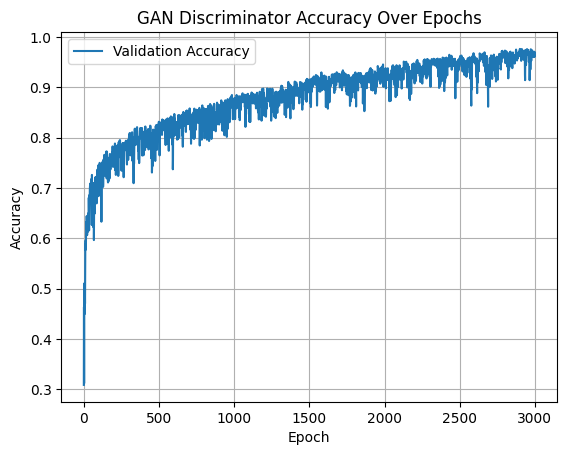

In [ ]:
# STEP 6: Accuracy Plot
plt.plot(acc_history, label='Validation Accuracy')
plt.title("GAN Discriminator Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

In [12]:
y_pred_probs = discriminator.predict(X_real, batch_size=32)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_real, axis=1)

label_names = LabelEncoder().fit(df['aspect_category']).classes_

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_names, digits=4))
print(f"\n Accuracy: {accuracy_score(y_true, y_pred):.4f}")

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

 Classification Report:
                         precision    recall  f1-score   support

               ambience     0.9805    0.9617    0.9710       784
anecdotes/miscellaneous     0.9960    0.9431    0.9688      2091
                   food     0.9548    0.9870    0.9706      1692
                  price     0.9461    0.9877    0.9665       569
                service     0.9448    0.9884    0.9661       952

               accuracy                         0.9690      6088
              macro avg     0.9644    0.9736    0.9686      6088
           weighted avg     0.9699    0.9690    0.9690      6088


 Accuracy: 0.9690


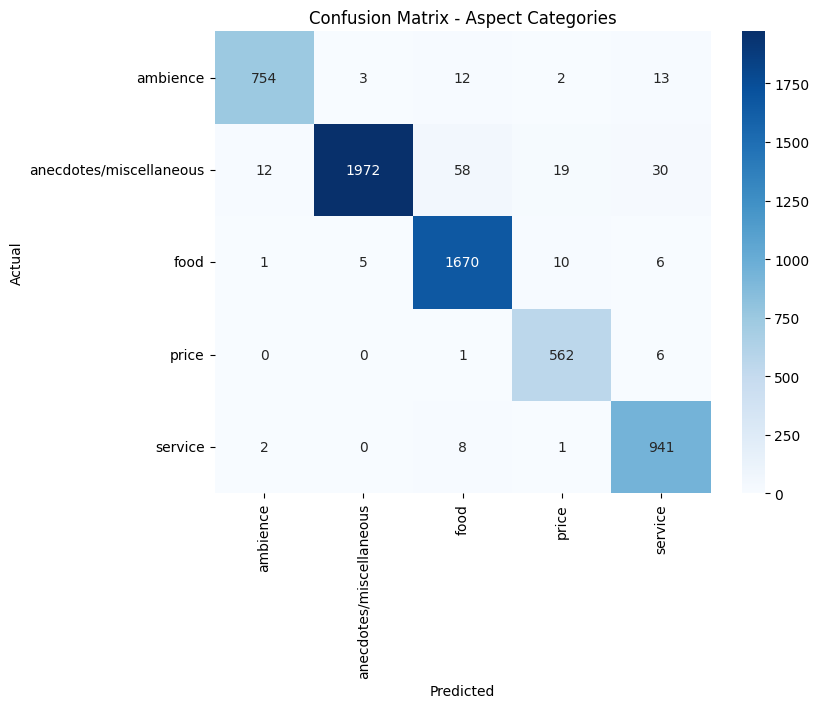

In [13]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap='Blues')
plt.title('Confusion Matrix - Aspect Categories')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [14]:
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)

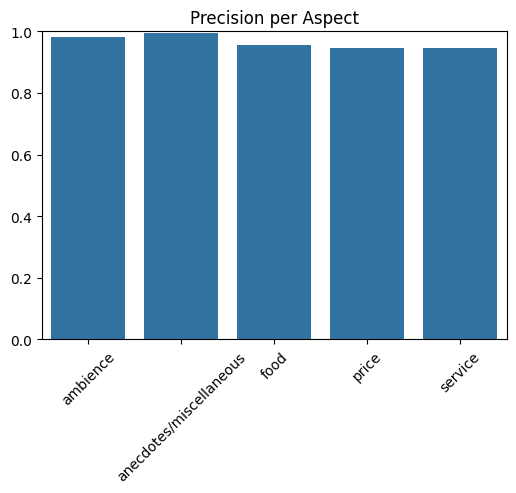

In [15]:
plt.figure(figsize=(6, 4))
sns.barplot(x=label_names, y=precision)
plt.title("Precision per Aspect")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

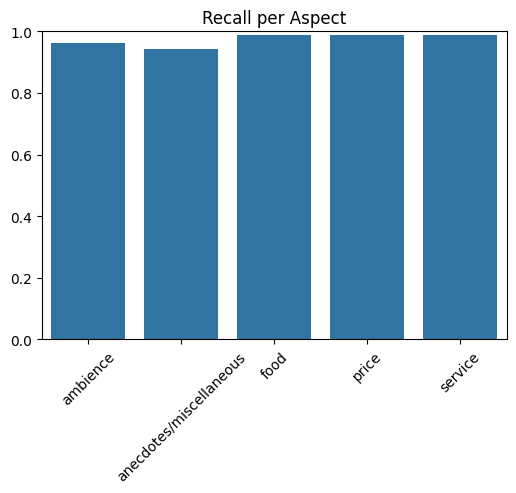

In [16]:
plt.figure(figsize=(6, 4))
sns.barplot(x=label_names, y=recall)
plt.title("Recall per Aspect")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

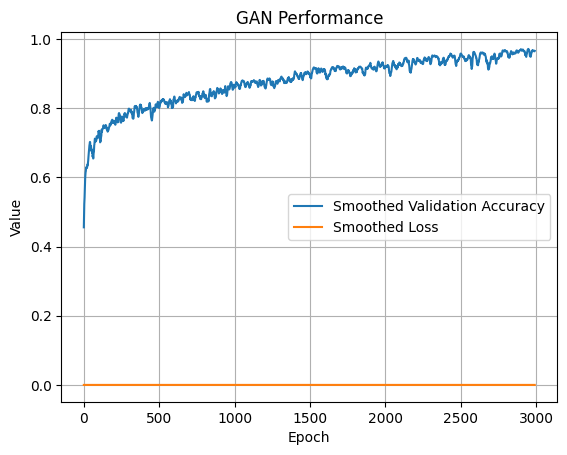

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have 'acc_history' and a similar 'loss_history' list

def moving_average(data, window_size):
    """Calculates the moving average of a list."""
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

# Set the window size for the moving average
window_size = 10  # You can adjust this value

# Calculate the moving averages
smoothed_acc = moving_average(acc_history, window_size)

# Initialize loss_history (replace with your actual loss data)
loss_history = [0] * len(acc_history)  # Example: initializing with zeros
# or
# loss_history = your_actual_loss_data  # Replace with your data

# Assuming you have a 'loss_history'
smoothed_loss = moving_average(loss_history, window_size)

# Plot the smoothed data
plt.plot(smoothed_acc, label='Smoothed Validation Accuracy')
plt.plot(smoothed_loss, label='Smoothed Loss')  # If you have loss data
plt.title("GAN Performance")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()